In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

# Let's look at the results
These are the results for when we just query the model to ask it the relationship after few-shot prompting with a single example.

In [1]:
!ls /home/chansingh/mntv1

anli_rough	 single_query_anli_9_12  suffix_anli_9_12
embedded-ngrams  single_query_math_9_12  suffix_math_9_12
projects	 single_query_rough


Load results

In [2]:
dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_12'
r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)


dir_suffix_search = '/home/chansingh/mntv1/suffix_anli_9_12' #/home/chansingh/mntv1/sweep_morning2'
r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

100%|██████████| 269/269 [00:21<00:00, 12.65it/s]


Index(['task_name', 'n_shots', 'max_dset_size', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'checkpoint',
       'max_num_tokens', 'beam_size', 'use_single_query', 'use_stopwords',
       'batch_size', 'seed', 'save_dir', 'use_cpu_only', 'use_parallelformers',
       'use_cache', 'use_verbose_saving', 'epoch_save_interval',
       'suffix_str_init', 'len_suffix_str_init', 'final_answer_full',
       'final_answer_added', 'final_model_queries',
       'final_num_suffixes_checked', 'final_answer_depth'],
      dtype='object')


100%|██████████| 48/48 [00:04<00:00, 10.86it/s]


Index(['task_name', 'n_shots', 'max_dset_size', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'checkpoint',
       'max_num_tokens', 'beam_size', 'use_single_query', 'use_stopwords',
       'batch_size', 'seed', 'save_dir', 'use_cpu_only', 'use_parallelformers',
       'use_cache', 'use_verbose_saving', 'epoch_save_interval',
       'suffix_str_init', 'len_suffix_str_init', 'final_answer_full',
       'final_answer_added', 'final_model_queries',
       'final_num_suffixes_checked', 'final_answer_depth'],
      dtype='object')


In [3]:
r_suffix_search.keys()

Index(['task_name', 'n_shots', 'max_dset_size', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'checkpoint',
       'max_num_tokens', 'beam_size', 'use_single_query', 'use_stopwords',
       'batch_size', 'seed', 'save_dir', 'use_cpu_only', 'use_parallelformers',
       'use_cache', 'use_verbose_saving', 'epoch_save_interval',
       'suffix_str_init', 'len_suffix_str_init', 'final_answer_full',
       'final_answer_added', 'final_model_queries',
       'final_num_suffixes_checked', 'final_answer_depth',
       'final_answer_found'],
      dtype='object')

Plot relevant results

In [4]:
def num_suffixes_checked_tab(tab):
    return (tab
            # mean over templates, task_name)
            .groupby(['checkpoint', 'n_shots'])['final_num_suffixes_checked', 'use_single_query']
            .mean()
            .reset_index()
            )            
tab_single_query = num_suffixes_checked_tab(r_single_query)
tab_suffix_search = num_suffixes_checked_tab(r_suffix_search)
tab = pd.concat((tab_single_query, tab_suffix_search)).sort_values('checkpoint')
tab['use_single_query'] = tab['use_single_query'].astype(bool)

/tmp/ipykernel_3070889/2134206703.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return (tab
/tmp/ipykernel_3070889/2134206703.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return (tab


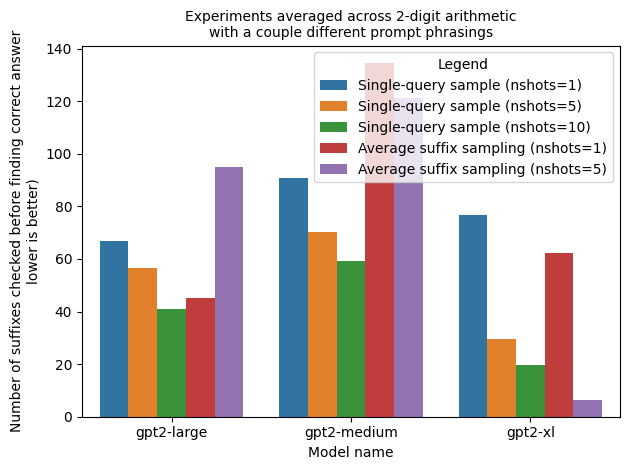

In [5]:
# reformat legend
VALS = {
    True: 'Single-query sample',
    False: 'Average suffix sampling',
}
tab['Legend'] = tab['use_single_query'].map(VALS) + ' (nshots=' + tab['n_shots'].astype(str) + ')'

# make plot
sns.barplot(x='checkpoint', y='final_num_suffixes_checked', hue='Legend', data=tab) #data=tab[tab['n_shots'] == 1])
plt.xlabel('Model name')
plt.ylabel('Number of suffixes checked before finding correct answer\nlower is better)')
plt.title('Experiments averaged across 2-digit arithmetic\nwith a couple different prompt phrasings', fontsize='medium')
plt.tight_layout()
plt.show()

# look at some of the tables

In [10]:
# cols_to_view = r_single_query.columns # cols_to_view
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]

In [11]:
r_single_query.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_model_queries  final_num_suffixes_checked  \
checkpoint  n_shots                                                    
gpt2-large  1                       3.42                       66.77   
            5                      12.50                       59.33   
gpt2-medium 1                       5.96                       90.59   
            5                       8.45                      106.36   
gpt2-xl     1                       7.26                       76.56   
            5                       1.00                        7.75   

                     final_answer_depth  final_answer_found  
checkpoint  n_shots                                          
gpt2-large  1                      1.27                0.87  
            5                      1.33                0.92  
gpt2-medium 1                      1.56                0.90  
            5                      1.73                0.79  
gpt2-xl     1                      1.44                0.90  
            5                      1.00                0.92

In [12]:
r_single_query.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates

final_model_queries  \
checkpoint  n_shots task_name                                                                 
gpt2-large  1       task088_identify_typo_verification                                21.33   
                    task092_check_prime_classification                                 1.00   
                    task107_splash_question_to_sql                                     1.00   
                    task1146_country_capital                                           1.00   
                    task1147_country_currency                                          1.00   
                    task1149_item_check_edible                                         2.00   
                    task1191_food_veg_nonveg                                           1.00   
                    task1336_peixian_equity_evaluation_corpus_gende...                 1.00   
                    task1509_evalution_antonyms                                        1.00   
                    task183_rhyme_generation                                            NaN   
            5       task1146_country_capital                                           1.00   
                    task1147_country_currency                                          1.00   
                    task1149_item_check_edible                                        47.00   
                    task1509_evalution_antonyms                                        1.00   
                    task183_rhyme_generation                                            NaN   
gpt2-medium 1       task088_identify_typo_verification                                24.00   
                    task092_check_prime_classification                                 1.33   
                    task107_splash_question_to_sql                                     6.00   
                    task1146_country_capital                                           1.00   
                    task1147_country_currency                                          1.00   
                    task1149_item_check_edible                                         2.00   
                    task1191_food_veg_nonveg                                           1.00   
                    task1336_peixian_equity_evaluation_corpus_gende...                 1.00   
                    task1509_evalution_antonyms                                       16.33   
                    task183_rhyme_generation                                            NaN   
            5       task1146_country_capital                                           1.00   
                    task1147_country_currency                                          1.00   
                    task1149_item_check_edible                                         1.00   
                    task1509_evalution_antonyms                                       28.33   
                    task183_rhyme_generation                                            NaN   
gpt2-xl     1       task088_identify_typo_verification                                 8.00   
                    task092_check_prime_classification                                 1.00   
                    task107_splash_question_to_sql                                     1.00   
                    task1146_country_capital                                           1.00   
                    task1147_country_currency                                          1.00   
                    task1149_item_check_edible                                         7.00   
                    task1191_food_veg_nonveg                                           1.00   
                    task1336_peixian_equity_evaluation_corpus_gende...                12.00   
                    task1509_evalution_antonyms                                       33.33   
                    task183_rhyme_generation                                            NaN   
            5       task1146_country_capital                                      

In [13]:
r_suffix_search.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

,,final_model_queries,final_num_suffixes_checked,final_answer_depth,final_answer_found
checkpoint,n_shots,,,,
gpt2-large,1,1.43,45.00,1.14,0.78
gpt2-medium,1,16.29,134.43,2.00,0.78
gpt2-xl,1,3.11,62.11,1.33,0.90


In [14]:
r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_model_queries  \
checkpoint  n_shots task_name                                                                 
gpt2-large  1       task088_identify_typo_verification                                  4.0   
                    task092_check_prime_classification                                  1.0   
                    task1146_country_capital                                            1.0   
                    task1147_country_currency                                           1.0   
                    task1149_item_check_edible                                          NaN   
                    task1191_food_veg_nonveg                                            1.0   
                    task1336_peixian_equity_evaluation_corpus_gende...                  1.0   
                    task1509_evalution_antonyms                                         1.0   
                    task183_rhyme_generation                                            NaN   
gpt2-medium 1       task088_identify_typo_verification                                 41.0   
                    task092_check_prime_classification                                  2.0   
                    task1146_country_capital                                            1.0   
                    task1147_country_currency                                           1.0   
                    task1149_item_check_edible                                          NaN   
                    task1191_food_veg_nonveg                                            1.0   
                    task1336_peixian_equity_evaluation_corpus_gende...                  1.0   
                    task1509_evalution_antonyms                                        67.0   
                    task183_rhyme_generation                                            NaN   
gpt2-xl     1       task088_identify_typo_verification                                  2.0   
                    task092_check_prime_classification                                  1.0   
                    task107_splash_question_to_sql                                      1.0   
                    task1146_country_capital                                            1.0   
                    task1147_country_currency                                           1.0   
                    task1149_item_check_edible                                         19.0   
                    task1191_food_veg_nonveg                                            1.0   
                    task1336_peixian_equity_evaluation_corpus_gende...                  1.0   
                    task1509_evalution_antonyms                                         1.0   
                    task183_rhyme_generation                                            NaN   

                                                                        final_num_suffixes_checked  \
checkpoint  n_shots task_name                                                                        
gpt2-large  1       task088_identify_typo_verification                                       220.0   
                    task092_check_prime_classification                                        11.0   
                    task1146_country_capital                                                   1.0   
                    task1147_country_currency                                                  1.0   
                    task1149_item_check_edible                                                 NaN   
                    task1191_food_veg_nonveg                                                  44.0   
                    task1336_peixian_equity_evaluation_corpus_gende...                        21.0   
                    task1509_evalution_antonyms                                               17.0   
                    task183_rhyme_generation                                                   NaN   
gpt2-medium 1       task088_identify_typo_verification                                       485.0 

In [9]:
rg = r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])
rg = rg[['final_model_queries','final_num_suffixes_checked']].mean().round(2) # mean over templates, task_name
print(rg.to_latex())

\begin{tabular}{lllrr}
\toprule
        &   &              &  final\_model\_queries &  final\_num\_suffixes\_checked \\
checkpoint & n\_shots & task\_name &                      &                             \\
\midrule
gpt2-large & 1 & add\_two &                 1.33 &                        5.67 \\
        &   & divide\_two &                 2.89 &                        8.67 \\
        &   & multiply\_two &                 3.89 &                       10.44 \\
gpt2-medium & 1 & add\_two &                 3.11 &                        8.44 \\
        &   & divide\_two &                 1.33 &                        5.44 \\
        &   & multiply\_two &                 1.33 &                        4.78 \\
gpt2-xl & 1 & add\_two &                 2.33 &                       12.11 \\
        &   & divide\_two &                 5.11 &                       18.78 \\
        &   & multiply\_two &                 1.33 &                        6.78 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2765084/1313215481.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rg.to_latex())


# look at individual results

In [ ]:
results_dir = '/home/chansingh/mntv1/sweep0/Sep_02_21_24_zjpbgvrtlohx'
r = pkl.load(open(oj(results_dir, 'results_final.pkl'), 'rb'))
print(r)